In [1]:
# (C) Copyright IBM Corp. 2019, 2020, 2021, 2022.

#    Licensed under the Apache License, Version 2.0 (the "License");
#    you may not use this file except in compliance with the License.
#    You may obtain a copy of the License at

#           http://www.apache.org/licenses/LICENSE-2.0

#     Unless required by applicable law or agreed to in writing, software
#     distributed under the License is distributed on an "AS IS" BASIS,
#     WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#     See the License for the specific language governing permissions and
#     limitations under the License.


In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch

In [4]:
from simulai.metrics import L2Norm
from simulai.optimization import Optimizer
from simulai.regression import DenseNetwork
from simulai.residuals import SymbolicOperator

#### Global parameters.

In [5]:
N = 10_000
n = 1_000
T_max = 1
mu = 40

#### Time domains.

In [6]:
time_train = (np.random.rand(n) * T_max)[:, None]
time_eval = np.linspace(0, T_max, N)[:, None]

#### Ground truth solution.

In [7]:
def dataset(t):
    return np.exp(-t)

#### Ground truth data.

In [8]:
u_data = dataset(t=mu*time_eval)

#### Our ODE.
$$
\frac{du}{dt} + \mu\,u = 0
$$

In [9]:
f = "D(u, t) + mu*u"

#### Set up: variables names, number of epochs and learning rate.

In [10]:
input_labels = ["t"]
output_labels = ["u"]
n_inputs = len(input_labels)
n_outputs = len(output_labels)
n_epochs = 5_000 
lr = 1e-3 

#### The neural net model template.

In [11]:
def model():
    
    from simulai.models import ImprovedDenseNetwork
    from simulai.regression import SLFNN, ConvexDenseNetwork

    # Configuration for the fully-connected network
    config = {
        "layers_units": [50, 50, 50],
        "activations": "elu",
        "input_size": 1,
        "output_size": 1,
        "name": "net",
    }

    # Instantiating and training the surrogate model
    densenet = ConvexDenseNetwork(**config)
    encoder_u = SLFNN(input_size=1, output_size=50, activation="elu")
    encoder_v = SLFNN(input_size=1, output_size=50, activation="elu")

    net = ImprovedDenseNetwork(
        network=densenet,
        encoder_u=encoder_u,
        encoder_v=encoder_v,
        devices="gpu",
    )

    # It prints a summary of the network features
    net.summary()

    return net

#### Instantiating the model.

In [12]:
net = model()

ImprovedDenseNetwork(
  (network): ConvexDenseNetwork(
    (net_input): Linear(in_features=1, out_features=50, bias=True)
    (net_0): Linear(in_features=50, out_features=50, bias=True)
    (net_1): Linear(in_features=50, out_features=50, bias=True)
    (net_2): Linear(in_features=50, out_features=1, bias=True)
  )
  (encoder_u): SLFNN(
    (nnet_linear_op): Linear(in_features=1, out_features=50, bias=True)
    (activation): ELU(alpha=1.0)
  )
  (encoder_v): SLFNN(
    (nnet_linear_op): Linear(in_features=1, out_features=50, bias=True)
    (activation): ELU(alpha=1.0)
  )
)


#### Optimizer configuration.

In [13]:
optimizer_config = {"lr": lr}

#### Extra parameters to be sent to the loss function.

#### Optimizer instance.

In [15]:
optimizer = Optimizer("adam", params=optimizer_config)

Optimizer adam found in torch.optim.


#### Symbolic residual instance.

In [16]:
residual = SymbolicOperator(
    expressions=[f],
    input_vars=["t"],
    output_vars=["u"],
    constants = {'mu': mu},
    function=net,
    engine="torch",
    device="gpu",
)

In [17]:
params = {
    "residual": residual,
    "initial_input": np.array([0])[:, None],
    "initial_state": np.array([1]),
    "weights_residual": [1],
    "initial_penalty": 1000,
}

#### Executing the training. 

In [18]:
optimizer.fit(
    op=net,
    input_data=time_train,
    n_epochs=n_epochs,
    loss="pirmse",
    params=params,
    device="gpu",
)

There are extra trainable parameters.
pde:0.0029339564498513937 init:2.412207322777249e-09 bound:0.0  

#### Evaluating approximation error. 

In [19]:
approximated_data = net.eval(input_data=time_eval)
l2_norm = L2Norm()
error = 100 * l2_norm(data=approximated_data, reference_data=u_data, relative_norm=True)
print(f"Approximation error: {error} %")

Approximation error: 0.7764311447450737 %


#### Plotting 

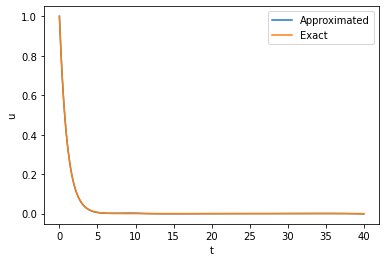

In [20]:
for ii in range(n_outputs):
    plt.plot(40*time_eval, approximated_data, label="Approximated")
    plt.plot(40*time_eval, u_data, label="Exact")
    plt.xlabel("t")
    plt.ylabel(f"{output_labels[ii]}")
    plt.legend()
    plt.show()

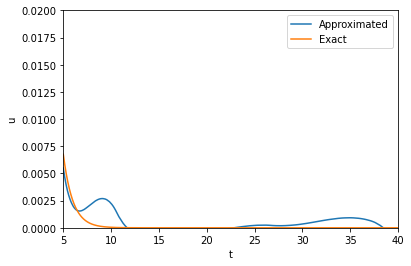

In [23]:
for ii in range(n_outputs):
    plt.plot(40*time_eval, approximated_data, label="Approximated")
    plt.plot(40*time_eval, u_data, label="Exact")
    plt.xlabel("t")
    plt.ylabel(f"{output_labels[ii]}")
    plt.xlim(5,40)
    plt.ylim(0, 0.02)
    plt.legend()
    plt.show()